The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## step1: camera calibration

用到的opencv函数

1.得到灰度图

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

2.Finding chessboard corners (for an 8x6 board):

ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

3.Drawing detected corners on an image:

img = cv2.drawChessboardCorners(img, (8,6), corners, ret)

4.标定相机Camera calibration

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

objpoints:对象点坐标，3D points in real world space

imgpoints:图像点坐标，2D points in image plane

5.图像矫正：Undistorting a test image:

dst = cv2.undistort(img, mtx, dist, None, mtx)

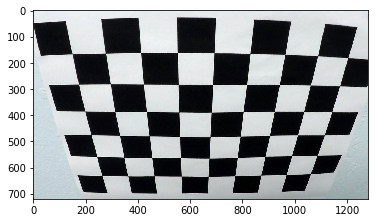

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

fname = './camera_cal/calibration2.jpg'
img = cv2.imread(fname)

plt.imshow(img)

corners find

### step1: 求得角点，标定相机

In [23]:
import glob
# Read in and make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')


# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y


#Arrays to store object points and image points from all the images
objpoints = []  #3D points in real world space
imgpoints= []   #2D points in image plane
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


for fname in images:
    #read in each image
    img = cv2.imread(fname)
     
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #plt.imshow(img)
        #plt.show()
        


In [24]:
# Read in an image
img = cv2.imread('./test_images/test5.jpg')

## step2: 畸变矫正

In [25]:
img_size = (img.shape[1],img.shape[0])
ret, g_mtx, g_dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_size,None,None)

In [28]:
# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return undist

### 测试相机矫正参数

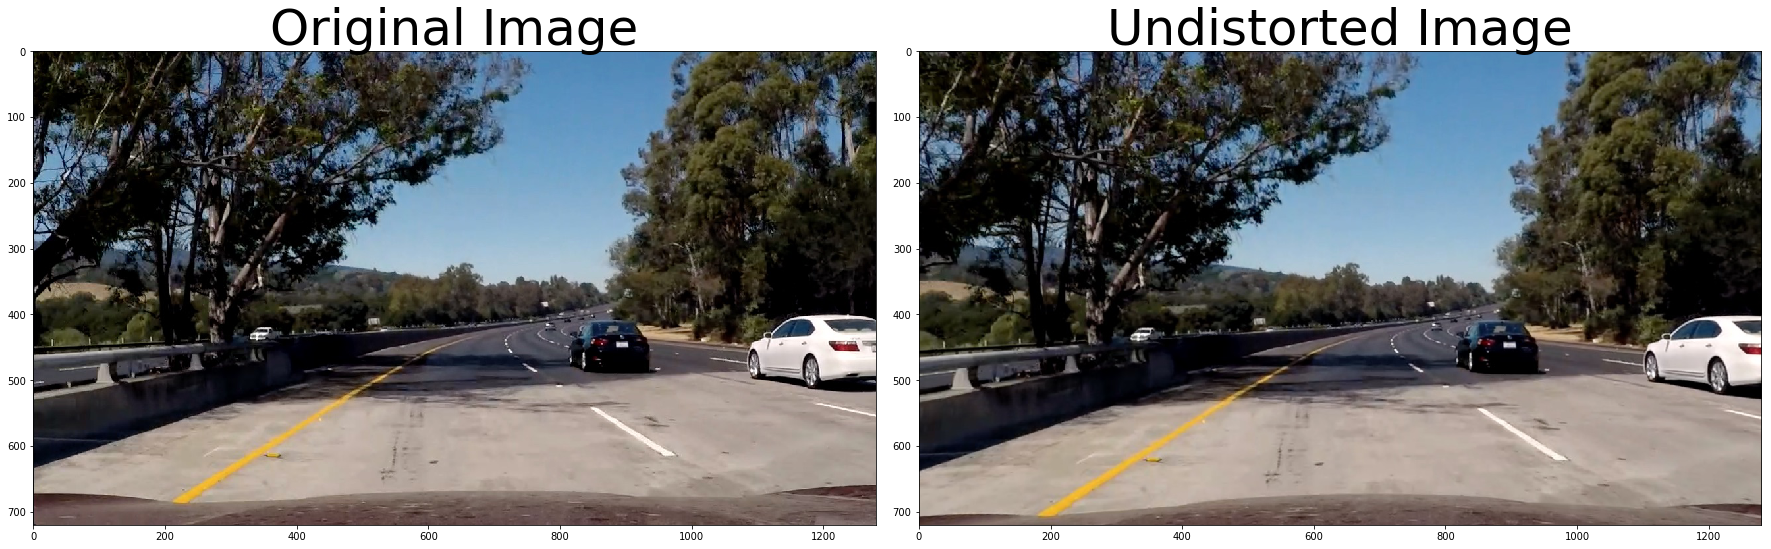

In [30]:
undistorted = cal_undistort(img, g_mtx, g_dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img[:,:,::-1])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted[:,:,::-1])
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## step3: 得到车道线阈值图

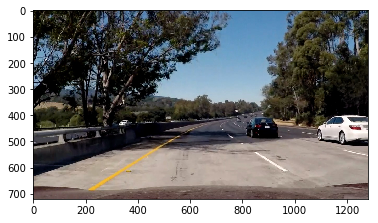

In [51]:

img3 = cv2.imread('./test_images/test5.jpg')
#img3 = cv2.imread('../udacity-project/step1/images/signs_vehicles_xygrad.png')
gray3 = cv2.cvtColor(img3, cv2.COLOR_RGB2GRAY)

# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size = 5
blur_gray3 = cv2.GaussianBlur(gray3,(kernel_size, kernel_size), 0)
plt.imshow(img3[:,:,::-1], cmap='Greys_r')
plt.show()

In [52]:
def abs_sobel_thresh(img, orient,sobel_kernel=3,thresh=(0,255)):
    thresh_min,thresh_max= thresh
    print(thresh_min,thresh_max)
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    if orient =='x':
        abs_sobel = np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1))
    
    #print(abs_sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    #print(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

20 200
20 100


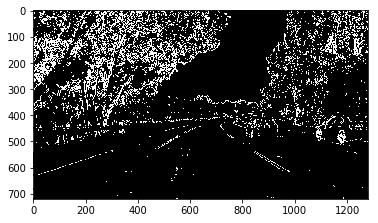

In [61]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img3, orient='x', sobel_kernel=ksize, thresh=(20, 200))
grady = abs_sobel_thresh(img3, orient='y', sobel_kernel=ksize, thresh=(20, 100))
plt.imshow(gradx,cmap='gray')

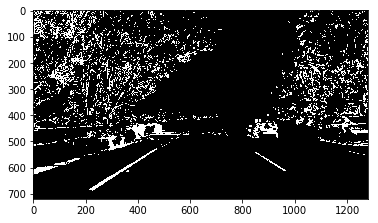

In [60]:
def color_binary(img,dst_format='HLS',ch=2,ch_thresh=[0,255]):
    '''
    Color thresholding on channel ch
    img:RGB
    dst_format:destination format(HLS or HSV)
    ch_thresh:pixel intensity threshold on channel ch
    output is binary image
    '''
    if dst_format =='HSV':
        img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        ch_binary = np.zeros_like(img[:,:,int(ch-1)])
        ch_binary[(img[:,:,int(ch-1)]>=ch_thresh[0])&(img[:,:,int(ch-1)]<=ch_thresh[1])] = 1
    else:
        img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
        ch_binary = np.zeros_like(img[:,:,int(ch-1)])
        ch_binary[(img[:,:,int(ch-1)]>=ch_thresh[0])&(img[:,:,int(ch-1)]<=ch_thresh[1])] = 1
    return ch_binary
ch_thresh = [150,255]
ch3_hls_binary = color_binary(img3,dst_format='HLS',ch=3,ch_thresh=ch_thresh)
plt.imshow(ch3_hls_binary,cmap='gray')

## step4: 视角透视转换，得到bird eye view

## step5: 拟合车道线曲线

## step6: 画出车道线，转换回原图

## step7: 测试视频
